In [1]:
# If you want to run this on Google Colab, just uncomment the following lines. Please note,
# that you will need to locate your folder directly in the root directory of your Google Drive (/content/drive/My Drive/).
# Because otherwise, it won't work out of the box and you would need to adjust the path in here.
#
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#
#import os
#os.chdir("/content/drive/My Drive/CSMP-Project")

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
data_file = '../../../data/RoughContact/newNorm4ML.csv'

column_names = ['normRMSH', 'normCurv' 'gammaNorm', 'muT', 'normPullOff']

dataset = pd.read_csv(data_file, sep=';')

dataset.dropna(inplace=True)

dataset

,normRMSH,normCurv,gammaNorm,muT,normPullOff
0,0.112520,14.54300,0.147337,0.238928,0.009895
1,0.149189,8.53679,0.099375,0.596627,0.000039
2,0.060246,93.13430,0.001107,0.314256,0.000133
3,0.148948,8.56467,0.081084,0.265387,0.022324
4,0.072831,48.90650,0.023706,0.334582,0.000205
...,...,...,...,...,...
229,0.043186,351.81200,0.950000,1.000000,0.019214
230,0.043186,351.81200,1.250000,1.000000,0.028896
231,0.043186,351.81200,1.800000,1.000000,0.052295
232,0.043186,351.81200,2.600000,1.000000,0.075791


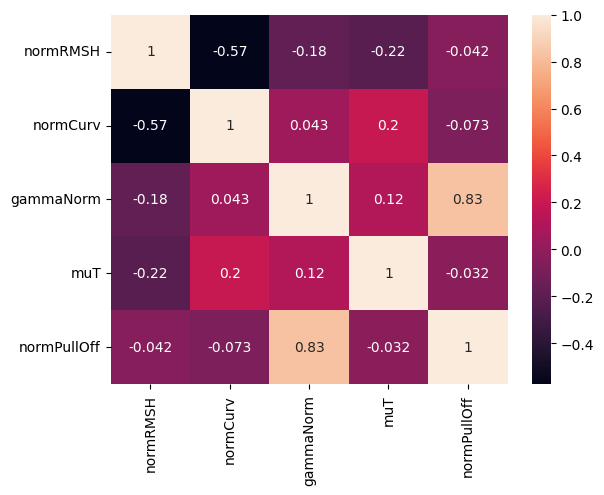

In [4]:
dataplot = sns.heatmap(dataset.corr(), cmap="rocket", annot=True)

plt.show()

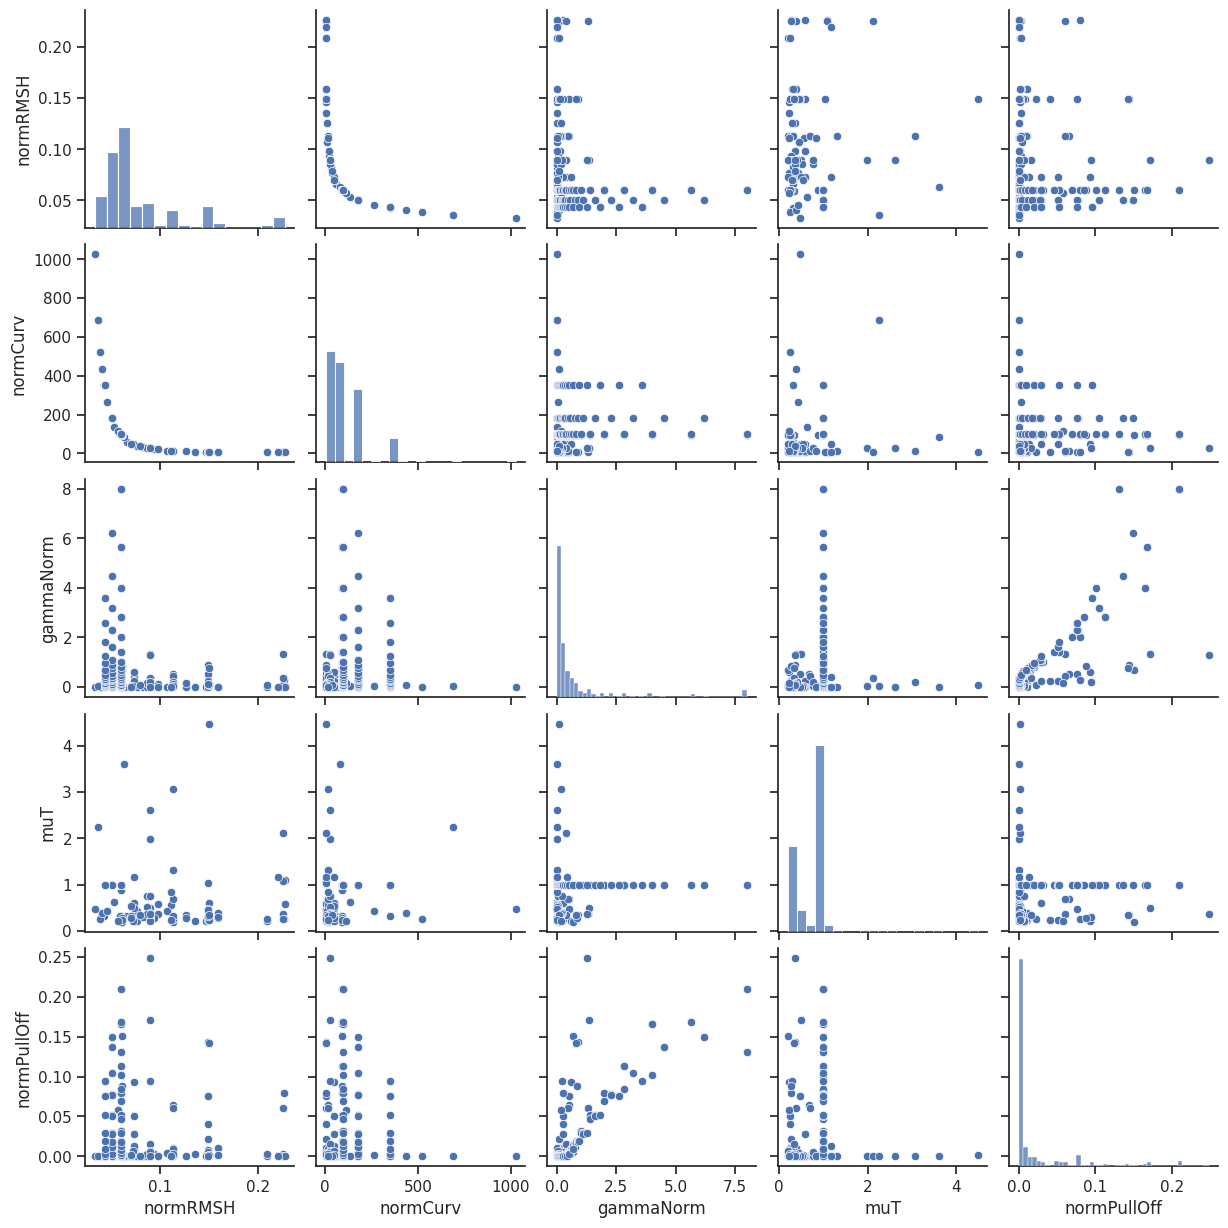

In [5]:
sns.set_theme(style="ticks")
sns.pairplot(dataset)

In [6]:
train_dataset = dataset.sample(frac=0.85)
test_dataset = dataset.drop(train_dataset.index)

len(train_dataset)

197

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('normPullOff')
test_labels = test_features.pop('normPullOff')

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState()

ada_regr = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=10), n_estimators=500, learning_rate=.1, random_state=rng
)

ada_regr.fit(train_dataset.drop(['normPullOff'], axis=1), train_labels)

preds = ada_regr.predict(test_dataset.drop(['normPullOff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPullOff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPullOff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPullOff'], preds))

Mean squared error: 0.0002829698
Root Mean squared error: 0.0168217073
Mean absolute error: 0.0081875683
Coefficient of determination: 0.91870


In [33]:
from sklearn.ensemble import RandomForestRegressor

randForestReg = RandomForestRegressor(n_estimators=500, criterion="absolute_error")
randForestReg.fit(train_dataset.drop(['normPullOff'], axis=1), train_labels)

preds = randForestReg.predict(test_dataset.drop(['normPullOff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPullOff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPullOff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPullOff'], preds))

Mean squared error: 0.0001780321
Root Mean squared error: 0.0133428672
Mean absolute error: 0.0064781397
Coefficient of determination: 0.94885


In [40]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(train_dataset.drop(['normPullOff'], axis=1), train_labels)

preds = knn_reg.predict(test_dataset.drop(['normPullOff'], axis=1))

# The mean squared error
mse = mean_squared_error(test_dataset['normPullOff'], preds)
print("Mean squared error: %.10f" % mse)
# The RSME
print("Root Mean squared error: %.10f" % np.sqrt(mse))
# The mean absolute error
print("Mean absolute error: %.10f" % mean_absolute_error(test_dataset['normPullOff'], preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(test_dataset['normPullOff'], preds))

Mean squared error: 0.0003210957
Root Mean squared error: 0.0179191427
Mean absolute error: 0.0086230519
Coefficient of determination: 0.90774


In [27]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
normRMSH,0.079383,0.043772
normCurv,115.601579,123.192074
gammaNorm,0.769077,1.481977
muT,0.849148,0.526500
normPullOff,0.026234,0.049868


In [42]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[7.87218511e-02 1.12368126e+02 6.68271780e-01 8.19610596e-01]]


In [43]:
def loss(y_true, y_pred):
  mse = keras.losses.mean_squared_error(y_true, y_pred)
  mae = keras.losses.mean_absolute_error(y_true, y_pred)
  return tf.math.sqrt(mse) + mae

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(1e-2))
  return model

In [44]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 128)               640       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [45]:
batch_size = len(train_dataset) - (int) (len(train_dataset) * 0.2)

history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000


/home/marc/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1/1 [==============================] - 2s 2s/step - loss: 3.1553 - val_loss: 0.2633
Epoch 2/2000
1/1 [==============================] - 0s 41ms/step - loss: 2.6525 - val_loss: 0.3851
Epoch 3/2000
1/1 [==============================] - 0s 42ms/step - loss: 2.6483 - val_loss: 0.4429
Epoch 4/2000
1/1 [==============================] - 0s 40ms/step - loss: 2.2896 - val_loss: 0.4688
Epoch 5/2000
1/1 [==============================] - 0s 41ms/step - loss: 2.2518 - val_loss: 0.4195
Epoch 6/2000
1/1 [==============================] - 0s 44ms/step - loss: 2.0603 - val_loss: 0.3393
Epoch 7/2000
1/1 [==============================] - 0s 47ms/step - loss: 1.9371 - val_loss: 0.3110
Epoch 8/2000
1/1 [==============================] - 0s 64ms/step - loss: 1.8338 - val_loss: 0.2330
Epoch 9/2000
1/1 [==============================] - 0s 42ms/step - loss: 1.6446 - val_loss: 0.1157
Epoch 10/2000
1/1 [==============================] - 0s 42ms/step - loss: 1.4148 - val_loss: 0.1717
Epoch 11/2000
1/1 [=====

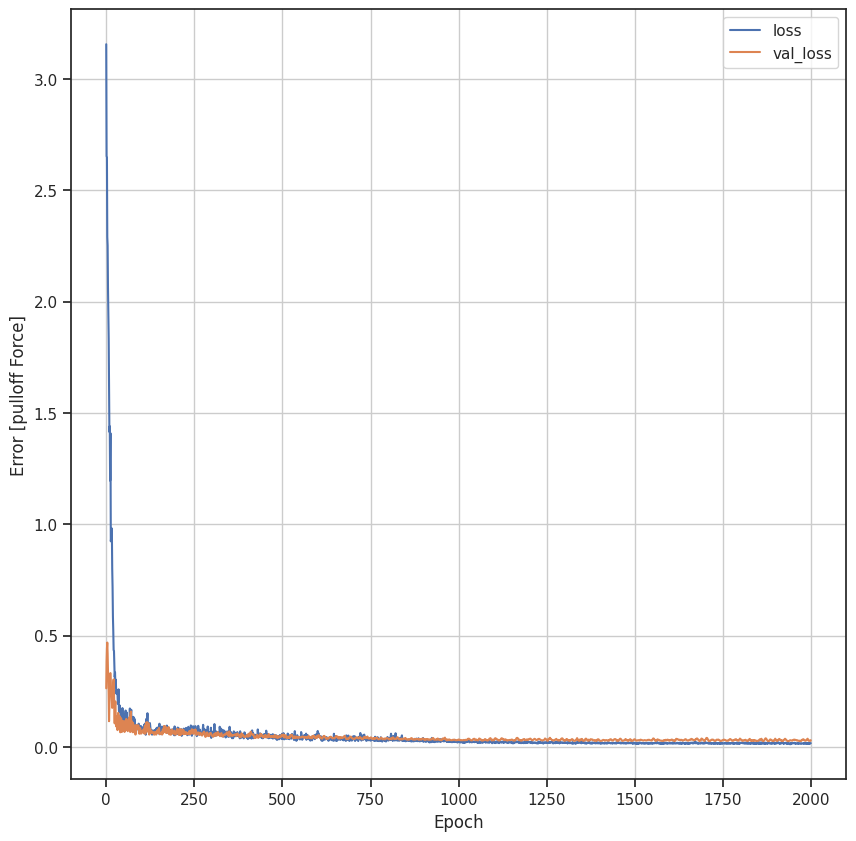

In [46]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

2/2 [==============================] - 0s 4ms/step


[]

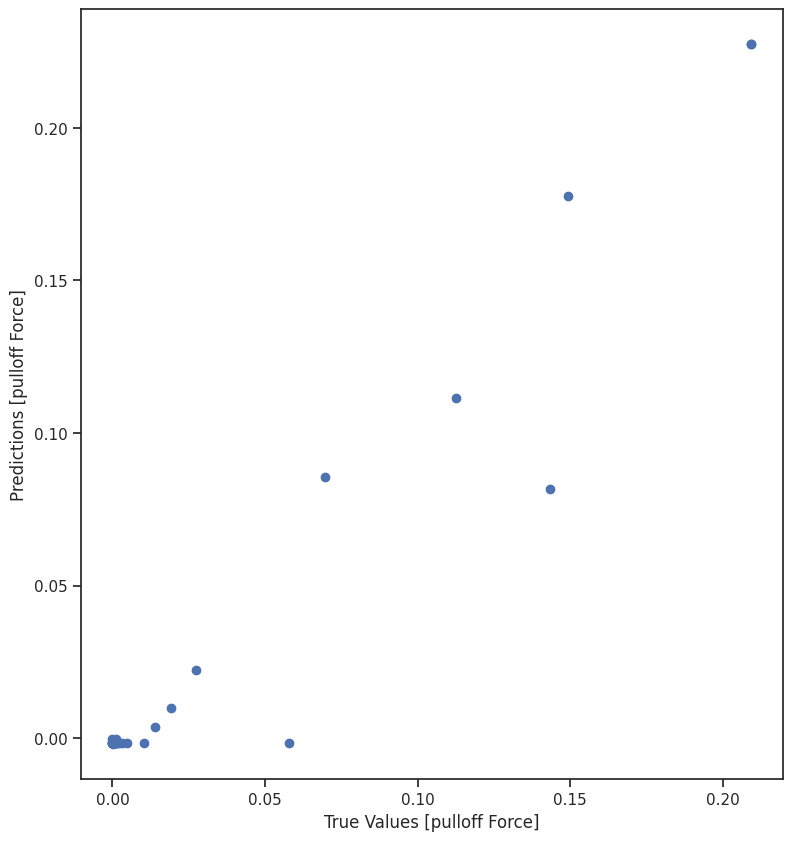

In [47]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')
plt.plot()

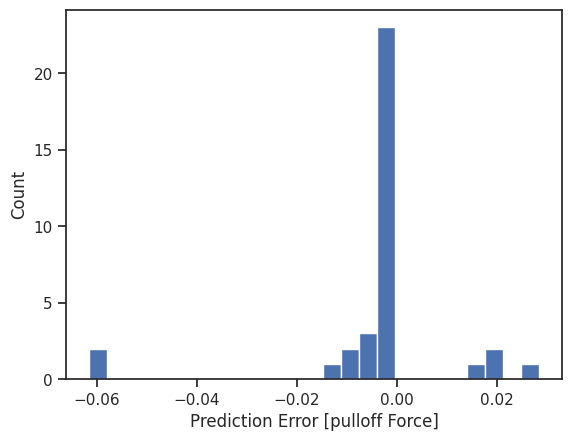

In [48]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [49]:
test_rmse = tf.math.sqrt(keras.losses.mean_squared_error(test_labels, test_predictions))
test_rmse.numpy()

0.016549084

In [50]:
dnn_model.save('norm_dnn_model')

INFO:tensorflow:Assets written to: norm_dnn_model/assets


INFO:tensorflow:Assets written to: norm_dnn_model/assets
